# Demos: Lecture 20

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

## Demo 1: `MultiRZ` and `PauliRot`

In [2]:
def ZZZ_CNOT(theta):
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.RZ(theta, wires=2)
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[0, 1])
    
def ZZZ_PauliRot(theta):
    qml.PauliRot(theta, 'ZZZ', wires=[0, 1, 2])
    
def RZRZRZ(theta):
    qml.RZ(theta, wires=0)
    qml.RZ(theta, wires=1)
    qml.RZ(theta, wires=2)

In [3]:
mat1 = qml.transforms.get_unitary_matrix(ZZZ_CNOT)(-0.2)
mat2 = qml.transforms.get_unitary_matrix(ZZZ_PauliRot)(-0.2)
mat3 = qml.transforms.get_unitary_matrix(RZRZRZ)(-0.2)

In [4]:
np.allclose(mat1, mat2)

True

In [5]:
np.allclose(mat1, mat3)

False

In [6]:
dev = qml.device('default.qubit', wires=3)

@qml.qnode(dev)
def circuit(theta):
    qml.PauliRot(theta, 'ZZZ', wires=range(3))
    return qml.probs(wires=0)

In [11]:
print(qml.draw(circuit, expansion_strategy="device")(-0.2))

 0: ──────╭X──RZ(-0.2)──╭X──────┤ Probs 
 1: ──╭X──╰C────────────╰C──╭X──┤       
 2: ──╰C────────────────────╰C──┤       



In [9]:
dev.operations.remove("MultiRZ")

In [18]:
dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev)
def circuit(theta):
    qml.PauliRot(theta, 'YYYY', wires=range(4))
    return qml.probs(wires=0)

In [19]:
print(qml.draw(circuit, expansion_strategy="device")(-0.2))

 0: ──RX(1.57)──────────╭X──RZ(-0.2)──╭X───RX(-1.57)─────────────────────────┤ Probs 
 1: ──RX(1.57)──────╭X──╰C────────────╰C──╭X───────────RX(-1.57)─────────────┤       
 2: ──RX(1.57)──╭X──╰C────────────────────╰C──────────╭X──────────RX(-1.57)──┤       
 3: ──RX(1.57)──╰C────────────────────────────────────╰C──────────RX(-1.57)──┤       



## Demo 2: commuting Pauli terms

In [21]:
pauli_1 = 'XZIX'
pauli_2 = 'YIZY'

In [22]:
qml.grouping.is_commuting(
    qml.grouping.string_to_pauli_word(pauli_1), # qml.PauliX(0) @ qml.PauliZ(1)...
    qml.grouping.string_to_pauli_word(pauli_2),
)

True

In [23]:
@qml.qnode(dev)
def circuit_1(theta, phi):
    qml.PauliRot(theta, pauli_1, wires=range(4))
    qml.PauliRot(phi, pauli_2, wires=range(4))
    return qml.probs(wires=0)

@qml.qnode(dev)
def circuit_2(theta, phi):
    qml.PauliRot(phi, pauli_2, wires=range(4))
    qml.PauliRot(theta, pauli_1, wires=range(4))
    return qml.probs(wires=0)

In [24]:
print(qml.draw(circuit_1, expansion_strategy="device")(0.4, 0.8))

 0: ──H──────╭X──RZ(0.4)──╭X───H──RX(1.57)────────────────╭X──RZ(0.8)──╭X───RX(-1.57)─────────────┤ Probs 
 1: ─────╭X──╰C───────────╰C──╭X──────────────────────────│────────────│──────────────────────────┤       
 2: ─────│────────────────────│───────────────────────╭X──╰C───────────╰C──╭X─────────────────────┤       
 3: ──H──╰C───────────────────╰C──H─────────RX(1.57)──╰C───────────────────╰C──────────RX(-1.57)──┤       



In [25]:
print(qml.draw(circuit_2, expansion_strategy="device")(0.4, 0.8))

 0: ──RX(1.57)──────╭X──RZ(0.8)──╭X───RX(-1.57)──H─────────────────╭X──RZ(0.4)──╭X───H─────┤ Probs 
 1: ────────────────│────────────│─────────────────────────────╭X──╰C───────────╰C──╭X─────┤       
 2: ────────────╭X──╰C───────────╰C──╭X────────────────────────│────────────────────│──────┤       
 3: ──RX(1.57)──╰C───────────────────╰C──────────RX(-1.57)──H──╰C───────────────────╰C──H──┤       



In [26]:
mat1 = qml.transforms.get_unitary_matrix(circuit_1)(0.4, 0.8)
mat2 = qml.transforms.get_unitary_matrix(circuit_2)(0.4, 0.8)

In [27]:
np.allclose(mat1, mat2)

True

## Demo 3: Trotterization

In [28]:
coeffs = [1.0, 2.0, 3.0, -1.0, -2.0, -3.0]

obs = [
    qml.PauliX(0) @ qml.PauliX(1),
    qml.PauliX(1) @ qml.PauliX(2),
    qml.PauliX(2) @ qml.PauliX(0),
    qml.PauliZ(0),
    qml.PauliZ(1),
    qml.PauliZ(2),
]

H = qml.Hamiltonian(coeffs, obs)

H_mat = np.array(
    [
        [-6.0, 0.0, 0.0, 2.0, 0.0, 3.0, 1.0, 0.0],
        [0.0, 0.0, 2.0, 0.0, 3.0, 0.0, 0.0, 1.0],
        [0.0, 2.0, -2.0, 0.0, 1.0, 0.0, 0.0, 3.0],
        [2.0, 0.0, 0.0, 4.0, 0.0, 1.0, 3.0, 0.0],
        [0.0, 3.0, 1.0, 0.0, -4.0, 0.0, 0.0, 2.0],
        [3.0, 0.0, 0.0, 1.0, 0.0, 2.0, 2.0, 0.0],
        [1.0, 0.0, 0.0, 3.0, 0.0, 2.0, 0.0, 0.0],
        [0.0, 1.0, 3.0, 0.0, 2.0, 0.0, 0.0, 6.0],
    ]
)

U = expm(-1j * H_mat)

In [34]:
dev = qml.device('default.qubit', wires=3)

@qml.qnode(dev, expansion_strategy="device")
def hamiltonian_simulation(t, n):
    qml.ApproxTimeEvolution(H, t, n)
    return qml.probs(wires=0)

In [33]:
print(qml.draw(hamiltonian_simulation)(0.3, 1))

 0: ──H──╭X──RZ(0.6)──╭X──H──H────────────────────────────────╭C───────────╭C──H──RZ(-0.6)──┤ Probs 
 1: ──H──╰C───────────╰C──H──H──╭X──RZ(1.2)──╭X──H──RZ(-1.2)──│────────────│────────────────┤       
 2: ──H─────────────────────────╰C───────────╰C──H──H─────────╰X──RZ(1.8)──╰X──H──RZ(-1.8)──┤       



In [41]:
num_steps = range(1, 21)

errors = []
depth = []
num_gates = []

for n in num_steps:
    mat = qml.transforms.get_unitary_matrix(hamiltonian_simulation)(1, n)
    error = np.linalg.norm(U - mat)
    errors.append(error)
    
    resources = qml.specs(hamiltonian_simulation)(1, n)
    depth.append(resources['depth'])
    num_gates.append(resources['num_operations'])    

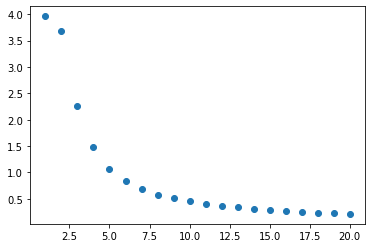

In [42]:
plt.scatter(num_steps, errors)

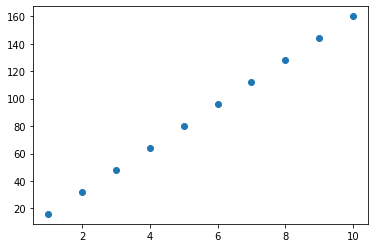

In [39]:
plt.scatter(num_steps, depth)

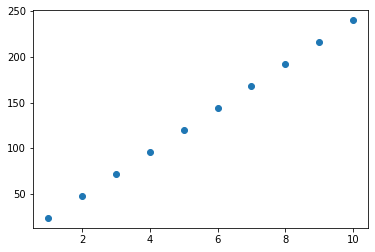

In [40]:
plt.scatter(num_steps, num_gates)